In [1]:
from BranchingProcess import Person, BranchingProcess, read_from_files
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, geom, chisquare
from datetime import datetime

<h2>Задание 1</h2>

In [2]:
# читаем вариант    
variant = "U M C Q R F O J P D".split(" ")
file_names = ["data/" + letter + ".txt" for letter in variant]
processes = read_from_files(file_names)

In [3]:
# удаляем все процессы, состоящие только из одного поколения
print ("Было процессов ", len(processes))
# выкидываем женщин=)
for p in range(0, len(processes)):
    for i in range(0, len(processes[p].generations)):
        new_generation = []
        for person in processes[p].generations[i]:
            if person.gender == "male":
                new_generation.append(person)
        if new_generation != []:
            processes[p].generations[i] = new_generation
        else:
            processes[p].generations = processes[p].generations[:i]
        
processes = [process for process in processes 
             if len(process.generations) > 1]
print ("После отбора осталось ", len(processes))

Было процессов  51890
После отбора осталось  10536


<h2>Задание 2</h2>

In [4]:
# число поколений
process_length = [len(process.generations) for process in processes]
print("Минимальное число поколений в роду ", np.min(process_length))
max_generation = np.max(process_length)
print("Максимальное число поколений в роду ", max_generation)
print("Среднее число поколений в роду ", np.average(process_length))

Минимальное число поколений в роду  2
Максимальное число поколений в роду  80
Среднее число поколений в роду  3.71241457859


In [5]:
# преобразует строку в дату все зависимости от полноты данных
def get_date(datestr):
    datelist = datestr.split("-")
    pattern = ""
    if (datelist[0] != ""):
        pattern += "%Y"
    pattern += "-"    
    if (datelist[1] != ""):
        pattern += "%b"
    pattern += "-"    
    if (datelist[2] != ""):
        pattern += "%d"
    return datetime.strptime(datestr, pattern)

# считает 
def get_age(person):
    birthday = get_date(person.birthday)
    deathday = get_date(person.deathdate)
    return ((deathday - birthday).days, person.birthday)
    
persons = [person for process in processes 
           for generation in process.generations 
           for person in generation]
good_persons = [person for person in persons 
                    if len(person.birthday.split("-")) == 3 
                     and len(person.deathdate.split("-")) == 3]

ages = [get_age(person) for person in good_persons]
ages = [age for age in ages if age[0] > 0]
ages_min = min(ages)
ages_max = max(ages)
ages_average = np.mean([item[0] for item in ages])
print("Среднем продолжительность жизни %d лет" 
      % int(ages_average / 365))
print("Самый молодой человек родился %s" % ages_min[1])
print("Самый человек старый родился %s" % ages_max[1])

Среднем продолжительность жизни 58 лет
Самый молодой человек родился 1682-Nov-25
Самый человек старый родился 1190--


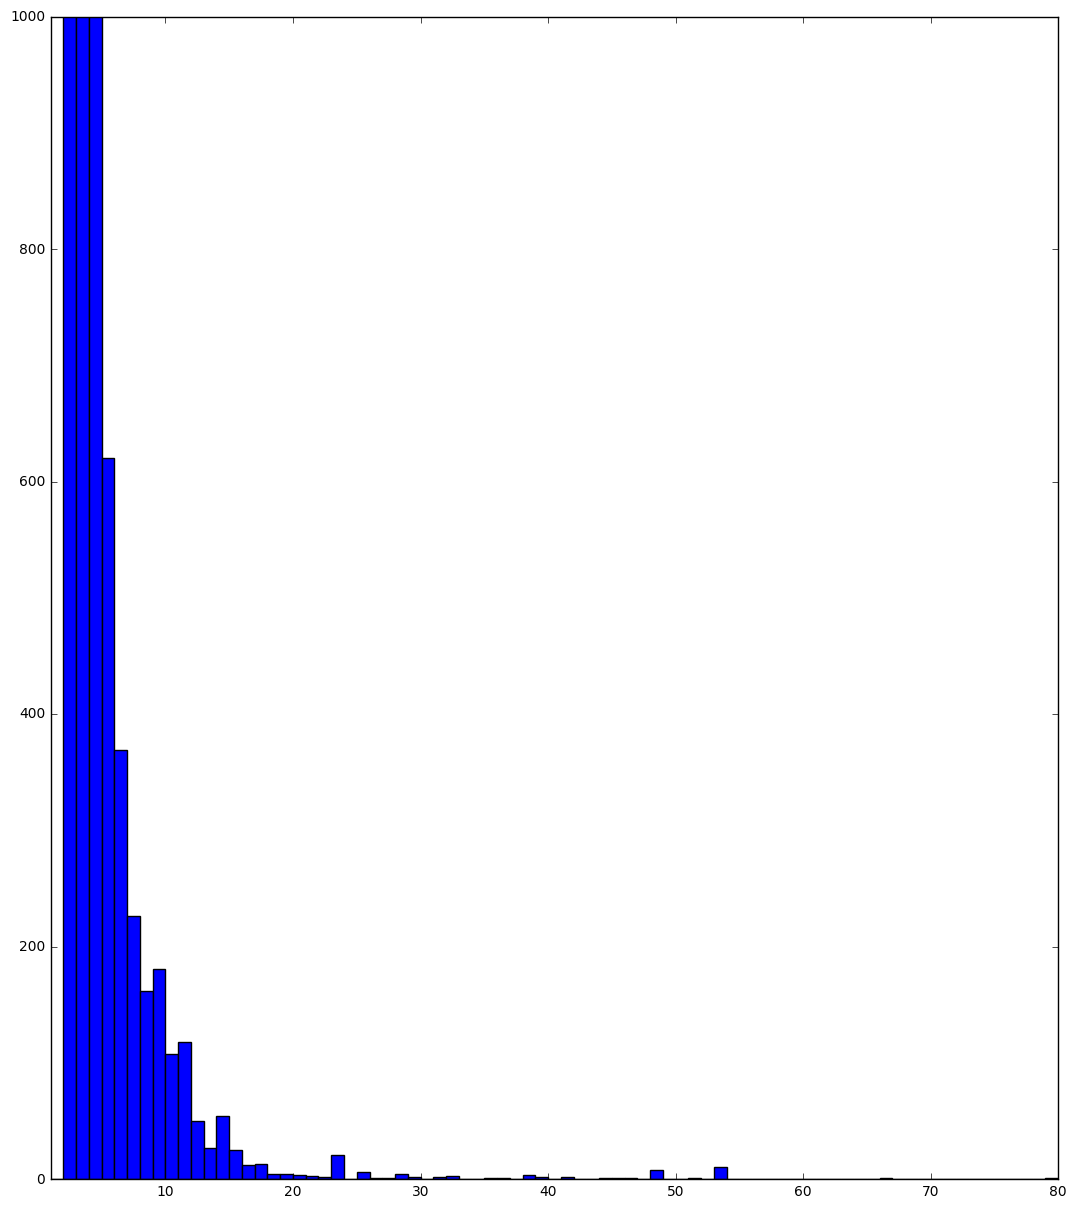

In [6]:
# распределение размера рода
plt.figure(figsize=(13, 15))
plt.hist(process_length, bins=range(0, max_generation + 1))
plt.ylim(0, 1000)
plt.xlim(1,max_generation)
plt.show()    

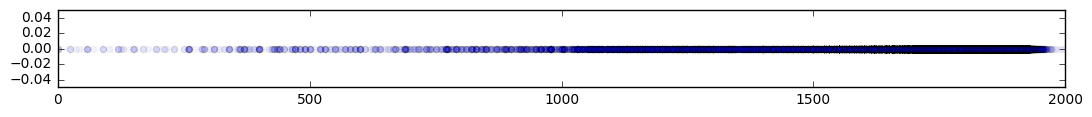

In [7]:
# года рождений, превосходная информативность
births = [int(datestr) 
          for datestr in [person.birthday.split("-")[0] 
                          for person in persons] 
          if datestr != ""]
plt.figure(figsize=(13, 1))
plt.scatter(births, np.zeros(len(births)), alpha=0.01)
plt.xlim(0, 2000)
plt.show()    

<h1>Задание 3</h1>
Оценка максимального правдоподобия для пуассоновского распределения - это $\overline X$

In [8]:
# собираем данные о размножении
def reproduction(process):
    reprod = []
    for i in range(1, len(process.generations)):
        fathers = process.generations[i - 1]
        sons = process.generations[i]
        names = [son.parents[0].replace(" ", "_") 
                 for son in sons 
                    if len(son.parents) > 0 
                     and (son.gender == 'male')]
        reprod.append([names.count(father.name) 
                       for father in fathers 
                       if father.gender == 'male'])
    return [x  for sublist in reprod for x in sublist]

In [9]:
sample = [reproduction(process) for process in processes]
# sample1 = [x + 1 for x in sample]
k_different = [np.mean(l) for l in sample]
p_different = [1. / (x + 1) for x in k_different]
# p_different = [np.mean(l) for l in sample1]
print("Законы размножения для различный процессов", k_different[:10])

# вариант для единого поколения
united_sample = [item for sublist in sample for item in sublist]
k_united = np.mean(united_sample)
p_united = 1. / (k_united + 1)
print("Значение оценки параметра распределения пуассона равно",
      k_united)
print("Значение оценки параметра геометрического распределения равно",
      p_united)

Законы размножения для различный процессов [1.0, 1.0, 1.2142857142857142, 1.0, 1.5, 1.0, 1.0, 1.3333333333333333, 2.0, 1.0]
Значение оценки параметра распределения пуассона равно 1.10092110168
Значение оценки параметра геометрического распределения равно 0.475981701168


In [10]:
# посчитаем эмперическое распределение
total_children = np.sum(united_sample)
emperical = [float(united_sample.count(i)) / total_children 
             for i in range(0, 10)]

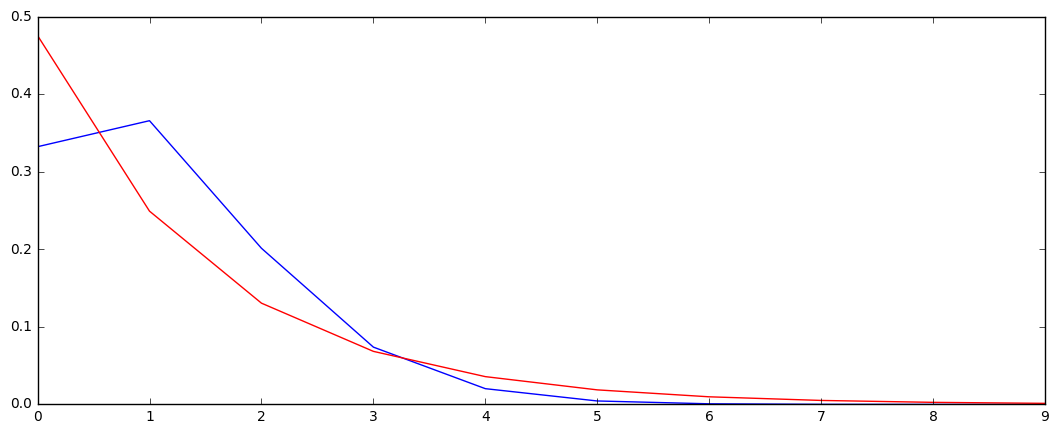

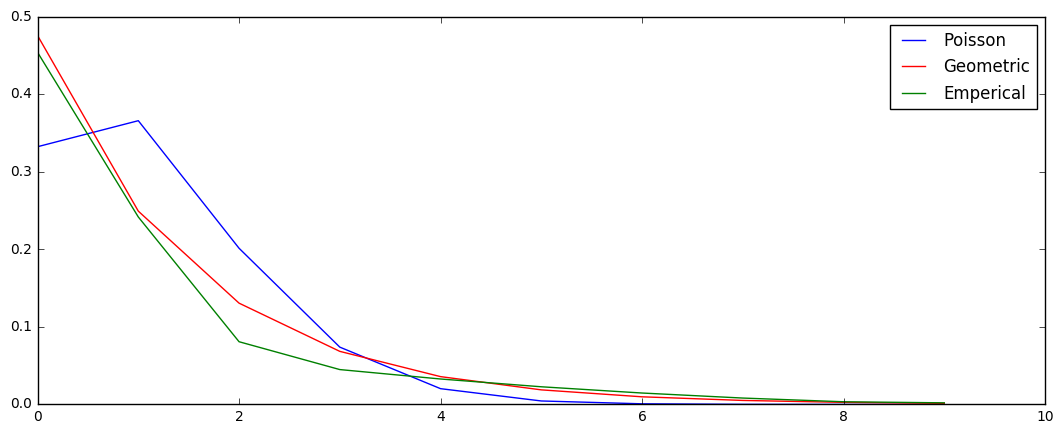

In [12]:
# строим график зависимости вероятности от числа потомков
plt.figure(figsize=(13, 5))
plt.plot(poisson.pmf(range(0, 10), k_united), color="blue", label="Poisson")
plt.plot(geom.pmf(range(0, 10), p_united, loc=-1), color="red", label="Geometric")
plt.plot(emperical, color="green", label="Emperical")
plt.xlim(0, 10)
plt.legend()
plt.show()

In [28]:
grid = [0, 1, 2, 3, 6, 15]
observed = []
expected_pois = []
expected_geom = []
for i in range(0, len(grid) - 1):
    observed.append(len([value for value in united_sample 
                         if value >= grid[i] 
                         and value < grid[i + 1]]))
    expected_pois.append(poisson.cdf(grid[i + 1], k_united) - 
                    poisson.cdf(grid[i], k_united))
    expected_geom.append(geom.cdf(grid[i + 1], p_united, loc=-1) - 
                    geom.cdf(grid[i], p_united, loc=-1))
observed = np.array(observed)
expected_pois = np.array(expected_pois) * len(united_sample)
expected_geom = np.array(expected_geom) * len(united_sample)
print(chisquare(observed, expected_pois).pvalue)
print(chisquare(observed, expected_geom).pvalue)

4.28470362197e-157
7.84818760106e-189


По критерию хи-квадрат можно сказать что найденый закон распределения далек от действительного, что так же можно наблюдать на графике. Видно так же что по сравнению с распределением пуассона, смещенное геометрическое распределение приближает закон размножения гораздо лучше.

<h2>Задание 5</h2>

Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=4, p=0.451613
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=3, p=0.400000
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=6, p=0.428571
Simulating process: initial=3, p=0.333333
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=2, p=0.428571
Simulating process: initial=2, p=0.400000
Вырождение! 0.4
Simulating process: initial=4, p=0.493333
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=2, p=0.400000
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating process: initial=1, p=0.500000
Вырождение! 0.5
Simulating

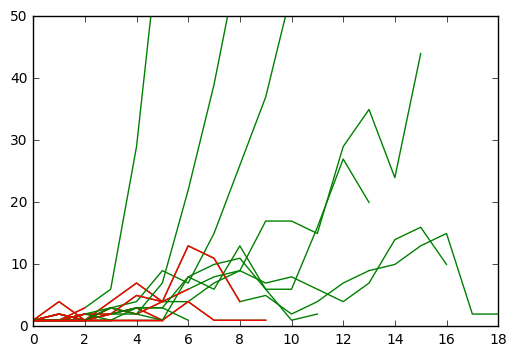

In [300]:
# моделирование процесса вперед
def simulate(initial, k, count):
    previous = initial
    print("Simulating process: initial=%d, p=%f" % (initial, k))
    generations = []
    for i in range(0, count):
        current = 0
        for person in range(0, previous):
            children_count = geom.rvs(k, size=1, loc=-1)[0]
            current += children_count
        previous = current
        if (current == 0):
            print('Вырождение!', k)
            break
        generations.append(previous)
    return generations

def get_last_gen(process):
    males = [person for person in process.generations[-1] 
             if person.gender == 'male']
    return len(males)

def get_prev_gen(process):
    return [len(generation) for generation in process.generations]

plt.figure()
for i in range(0, 20):
    plt.plot(get_prev_gen(processes[i]) + 
             simulate(get_last_gen(processes[i]), p_different[i], 10), color="green")
    plt.plot(get_prev_gen(processes[i]), color='red')
plt.ylim(0, 50) 
plt.show()